https://docs.ultralytics.com/datasets/pose/tiger-pose/#what-are-the-benefits-of-using-the-tiger-pose-dataset-for-pose-estimation

```
# Ultralytics YOLO 🚀, AGPL-3.0 license
# Tiger Pose dataset by Ultralytics
# Documentation: https://docs.ultralytics.com/datasets/pose/tiger-pose/
# Example usage: yolo train data=tiger-pose.yaml
# parent
# ├── ultralytics
# └── datasets
#     └── tiger-pose  ← downloads here (75.3 MB)

# Train/val/test sets as 1) dir: path/to/imgs, 2) file: path/to/imgs.txt, or 3) list: [path/to/imgs1, path/to/imgs2, ..]
path: ../datasets/tiger-pose # dataset root dir
train: train # train images (relative to 'path') 210 images
val: val # val images (relative to 'path') 53 images

# Keypoints
kpt_shape: [12, 2] # number of keypoints, number of dims (2 for x,y or 3 for x,y,visible)
flip_idx: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Classes
names:
  0: tiger

# Download script/URL (optional)
download: https://github.com/ultralytics/assets/releases/download/v0.0.0/tiger-pose.zip

```

In [2]:
import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

# Run the installation commands
!pip install opendatasets
!pip install ultralytics

# Clean up the notebook
clean_notebook()

Notebook cleaned.


In [3]:

import ultralytics
ultralytics.checks()

Ultralytics 8.3.47 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-80GB MIG 7g.80gb, 81051MiB)
Setup complete ✅ (256 CPUs, 2015.7 GB RAM, 288.3/3519.1 GB disk)


In [ ]:
from ultralytics import YOLO
from IPython.display import Image

# Load a model
model = YOLO("yolo11n-pose.pt")  # load a pretrained model (recommended for training)


# Train the model with the specified configuration
results = model.train(
    data="./tiger-pose.yaml",  # Path to dataset YAML file
    epochs=40,         # Number of training epochs
    imgsz=640,          # Image size (resolution)
    batch=10,           # Batch size
    device=0,           # Specify GPU (0) or CPU ('cpu')
    lr0=0.001,           # Initial learning rate
    optimizer="Adam",   # Optimizer (e.g., 'SGD', 'Adam')
    workers=16,          # Number of dataloader workers
    seed=42,            # Random seed for reproducibility
    patience=10,        # Early stopping patience (number of epochs)
    weight_decay=0.0005,  # Weight decay for regularization
    momentum=0.937,     # Momentum for SGD
    name="tiger",    # Name of the experiment folder
    verbose=True        # Print detailed training logs
)


In [ ]:

Image("./runs/pose/tiger/results.png", width=1200)

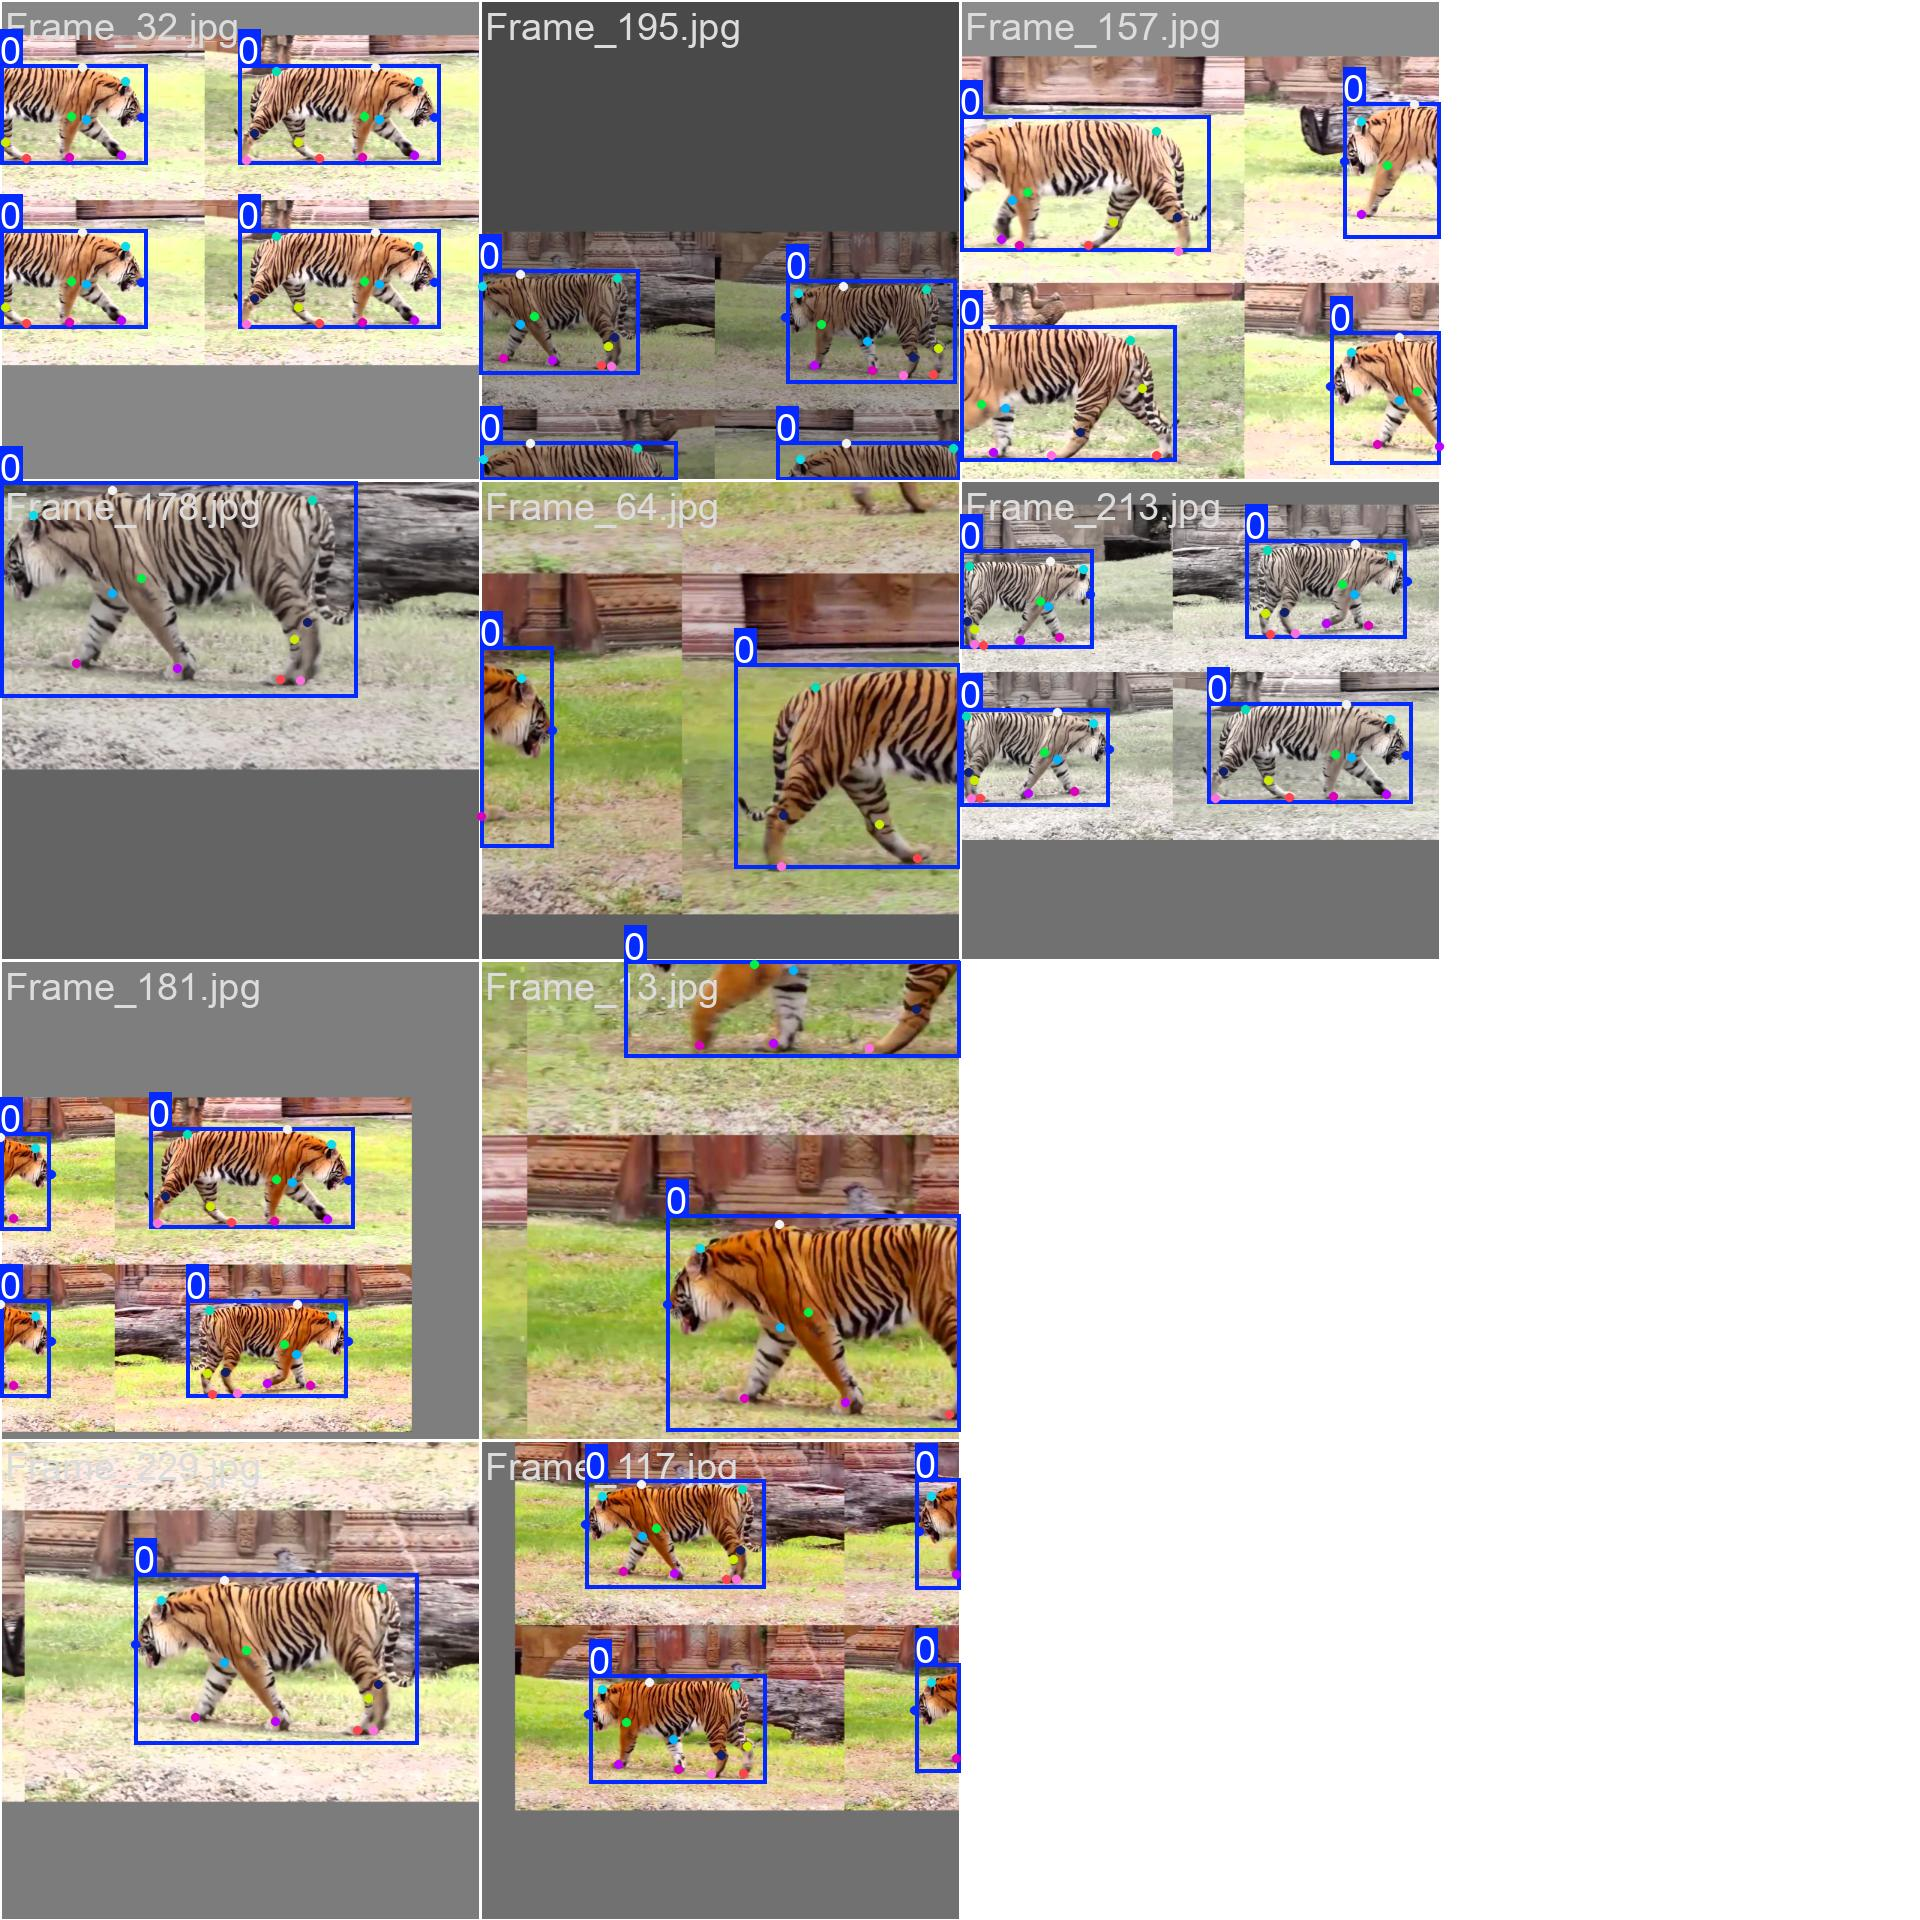

In [2]:
Image("./runs/pose/tiger/train_batch0.jpg", width=900)


image 1/1 /workspace/DL-FOR-COMPUTER-VISION/week07/datasets/tiger-pose/val/images/Frame_235.jpg: 384x640 1 tiger, 237.1ms
Speed: 2.2ms preprocess, 237.1ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


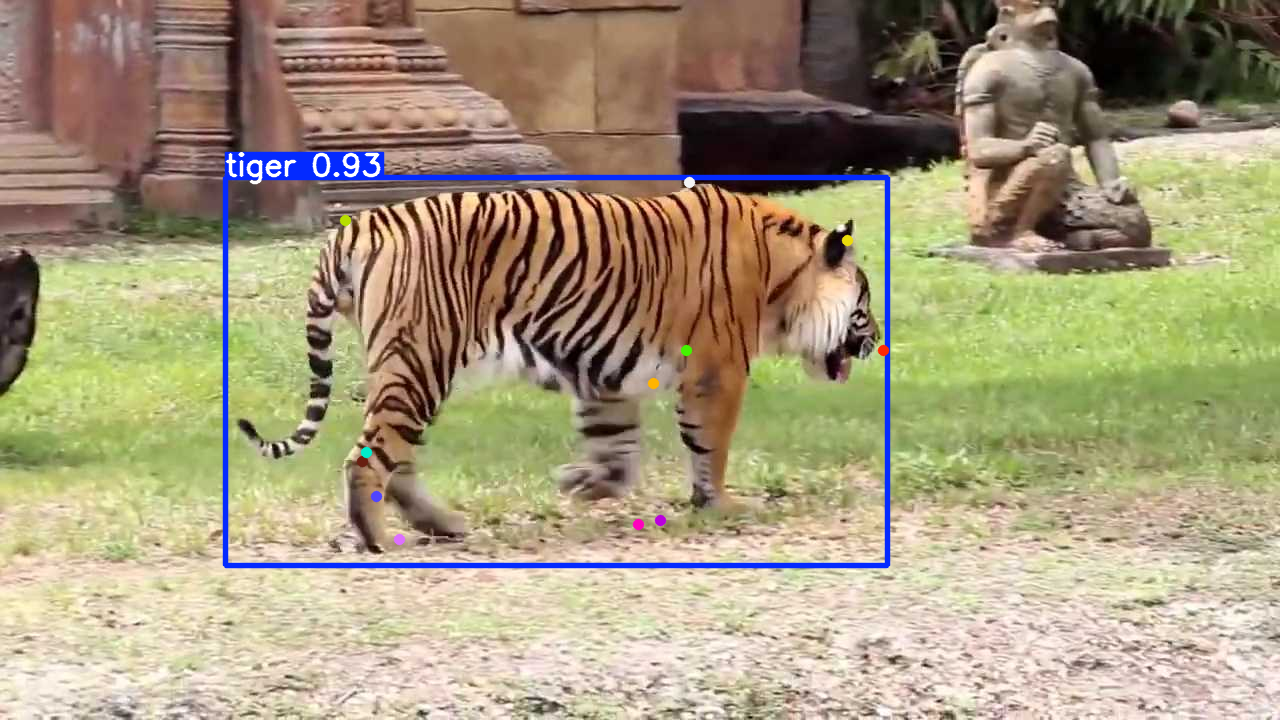

In [4]:
from ultralytics import YOLO
from IPython.display import Image


# Load a model
model = YOLO("./runs/pose/tiger/weights/best.pt")  # load a tiger-pose trained model



# Perform object detection on an image
results = model("./datasets/tiger-pose/val/images/Frame_235.jpg")
results[0].show()


In [9]:
results[0].keypoints.data

tensor([[[883.5445, 350.2264],
         [847.9454, 240.2557],
         [689.5063, 182.2141],
         [345.4612, 220.2086],
         [362.7652, 461.4440],
         [399.4818, 539.9353],
         [376.7742, 496.1476],
         [366.5604, 452.0191],
         [686.6019, 350.4698],
         [638.8651, 524.0024],
         [653.3724, 383.8223],
         [660.7234, 520.4663]]], device='cuda:0')

#  Pose Estimation with opencv

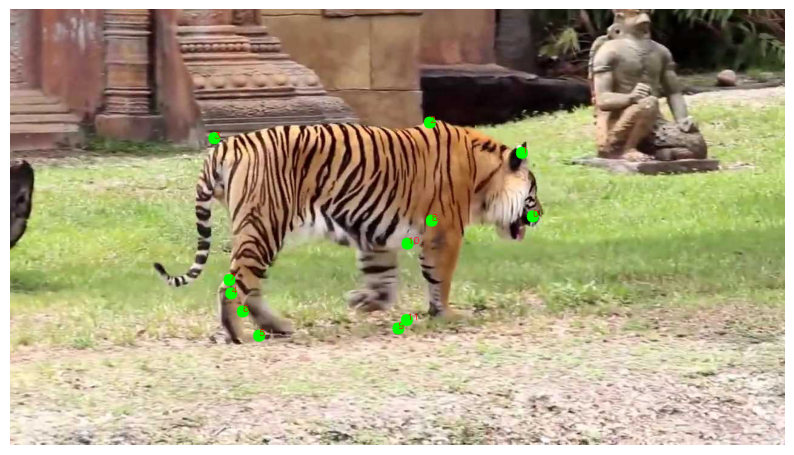

In [12]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("./datasets/tiger-pose/val/images/Frame_235.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = model(image_rgb,verbose=False)

# Iterate over detected persons
for person in results[0].keypoints.data.cpu().numpy():
   
    for idx, keypoint in enumerate(person):
        x, y = keypoint
        cv2.circle(image_rgb, (int(x), int(y)), radius=10, color=(0, 255, 0), thickness=-1)
        cv2.putText(image_rgb, str(idx), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Display the image using Matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

# To integrate reading a YouTube stream with Pose

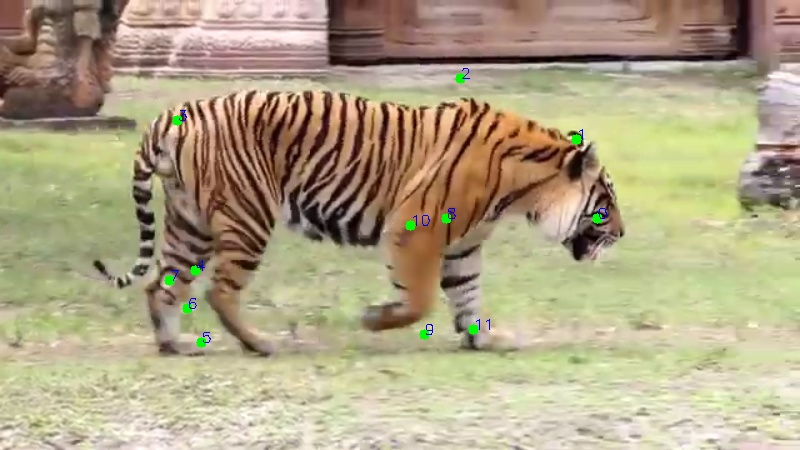

In [ ]:
import cv2
from IPython.display import display, Image, clear_output
from pytubefix import YouTube
from ultralytics import YOLO

# Set the desired width for resizing frames
set_width = 800

# Load your YOLO pose estimation model
model = YOLO("./runs/pose/tiger/weights/best.pt")  # Replace with your pose estimation model

# YouTube video URL
video_url = "https://youtu.be/MIBAT6BGE6U"

# Fetch the video stream URL using pytube
yt = YouTube(video_url)
video_stream = yt.streams.filter(file_extension='mp4', progressive=True).first()

if not video_stream:
    print("No compatible video stream found.")
    raise RuntimeError("Failed to fetch video stream.")

# Get the stream URL
stream_url = video_stream.url

# Open the YouTube stream in OpenCV
cap = cv2.VideoCapture(stream_url)

if not cap.isOpened():
    print(f"Error: Could not open YouTube video stream.")
    cap.release()
    raise RuntimeError("Video initialization failed.")

try:
    while True:
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            print("End of video or failed to grab frame.")
            break

        # Resize the frame for faster processing
        ratio = set_width / frame.shape[1]
        frame = cv2.resize(frame, (set_width, int(frame.shape[0] * ratio)))

        # Run pose estimation on the frame
        results = model(frame, verbose=False)

        # Iterate over detected persons and draw keypoints
        for person in results[0].keypoints.data.cpu().numpy():
            for idx, keypoint in enumerate(person):
                x, y = keypoint
                cv2.circle(frame, (int(x), int(y)), radius=5, color=(0, 255, 0), thickness=-1)
                cv2.putText(frame, str(idx), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # Encode the frame as JPEG
        _, buffer = cv2.imencode('.jpg', frame)
        img_bytes = buffer.tobytes()

        # Display the frame inline in the notebook
        display(Image(data=img_bytes))
        clear_output(wait=True)
finally:
    cap.release()
